In [ ]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize, OptimizeResult

from psd_utils import lnprob, grab_data
import emcee

def mcmc_debug_plot(sampler: emcee.EnsembleSampler, truths=None):
    import matplotlib.pyplot as plt
    import corner
    fig, axes = plt.subplots(sampler.ndim, 1)
    chain: np.ndarray = sampler.get_chain(discard=100) #type: ignore

    for i, (name, ax) in enumerate(zip(['nu_max', 'H', 'P', 'tau', 'alpha', 'W'], axes)):
        for walker_chain in chain[:, :, i]:
            ax.plot(walker_chain, color='black', alpha=0.25)
    
    corner.corner(sampler.get_chain(flat=True), truths=truths)

def do_mcmc(x0_logged_center: np.ndarray, freq, flux):
    ndim = len(x0_logged_center)
    n_walkers = 32

    sampler = emcee.EnsembleSampler(n_walkers, ndim, lnprob, args=(freq, flux))

    SPREAD = 1e-6
    x0_logged = x0_logged_center + SPREAD * np.random.randn(n_walkers, ndim)

    N_STEPS = 1_000
    sampler.run_mcmc(x0_logged, N_STEPS, progress=True)
    print(sampler.chain.shape)

    mcmc_debug_plot(sampler, truths=x0_logged_center)

    return sampler.get_chain()

def process_star(kic_id: str, star_row: pd.Series):
    freq, powers = grab_data(kic_id)

    W0 = np.mean(powers[-40:])

    x0 = np.array(list(star_row[["nu_max", "H", "P", "tau", "alpha"]]) + [W0])
    
    x0_logged = x0.copy()
    x0_logged[[1, 2, 3, 5]] = np.log10(x0[[1, 2, 3, 5]])
    
    min_res: OptimizeResult = minimize(lambda t: -lnprob(t, freq, powers)/len(freq), x0_logged)
    chain = do_mcmc(min_res.x, freq, powers)

    min_res.x[[1, 2, 3, 5]] = 10**(min_res.x[[1, 2, 3, 5]])

    return min_res


In [29]:
import os
data = pd.read_csv(os.environ.get("RED_GIANT_DATA_PATH", ""), index_col="KIC")
data

,M,R,Teff,FeH,e_M,e_R,e_Teff,e_FeH,nu_max,Delta_nu,...,e_H,e_P,e_tau,e_alpha,e_taue,e_sigma2,phase,e_phase,KepMag,e_KepMag
KIC,,,,,,,,,,,,,,,,,,,,,
757137,1.55,13.26,4751.0,-0.08,0.13,0.39,139.0,0.30,29.99,3.399,...,1110.534930,502.749775,215.638385,0.03515,541.165310,8715.196220,1.0,0.0,9.196,0.0
892010,1.42,16.37,4834.0,0.21,0.29,1.38,151.0,0.30,17.85,2.427,...,14893.714185,5032.136405,575.473725,0.09222,1585.198635,71270.148050,0.0,0.0,11.666,0.0
892738,1.15,23.15,4534.0,-0.25,0.21,1.62,135.0,0.30,7.48,1.300,...,33953.469420,26729.832780,1293.639330,0.02934,3283.591540,82742.072935,0.0,0.0,11.729,0.0
892760,1.00,10.52,5188.0,-0.21,0.14,0.68,183.0,0.30,29.48,3.962,...,6734.658605,897.348820,313.491245,0.16776,844.831955,34890.403310,2.0,0.0,13.228,0.0
893214,1.54,11.29,4728.0,-0.15,0.09,0.24,80.0,0.15,41.39,4.311,...,630.598035,484.902140,371.881760,0.03161,767.999165,7997.566190,1.0,0.0,12.581,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12884930,1.37,11.03,4906.0,-0.09,0.15,0.57,80.0,0.15,37.81,4.335,...,2253.377100,546.086530,360.902495,0.06183,825.982675,13011.709825,2.0,0.0,12.777,0.0
12885005,0.84,9.80,5077.0,-0.53,0.10,0.43,154.0,0.30,28.74,4.054,...,5866.270755,1372.093695,500.607585,0.12332,1281.901020,32985.376350,2.0,0.0,13.689,0.0
12885196,1.46,7.29,4846.0,0.07,0.09,0.16,142.0,0.30,92.86,8.187,...,305.584595,169.615255,298.402045,0.03490,395.026355,4106.941750,1.0,0.0,12.596,0.0


100%|██████████| 100/100 [00:04<00:00, 21.20it/s]


(32, 100, 6)


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.481063286885295
        x: [ 3.037e+01  6.051e+03  1.885e+04  1.055e+04  3.229e+00
             2.027e+01]
      nit: 29
      jac: [-5.960e-08  1.192e-07  1.252e-06 -6.676e-06 -1.371e-06
             1.967e-06]
 hess_inv: [[ 6.870e+02 -3.105e+01 ...  4.960e+00  1.382e+00]
            [-3.105e+01  7.743e+00 ... -7.955e+00 -3.879e-01]
            ...
            [ 4.960e+00 -7.955e+00 ...  4.834e+01  2.928e+00]
            [ 1.382e+00 -3.879e-01 ...  2.928e+00  6.375e-01]]
     nfev: 217
     njev: 31

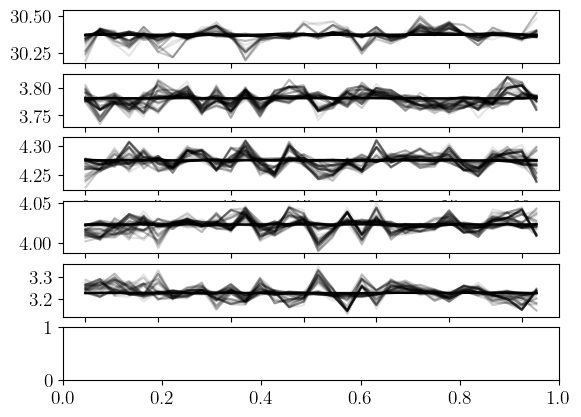

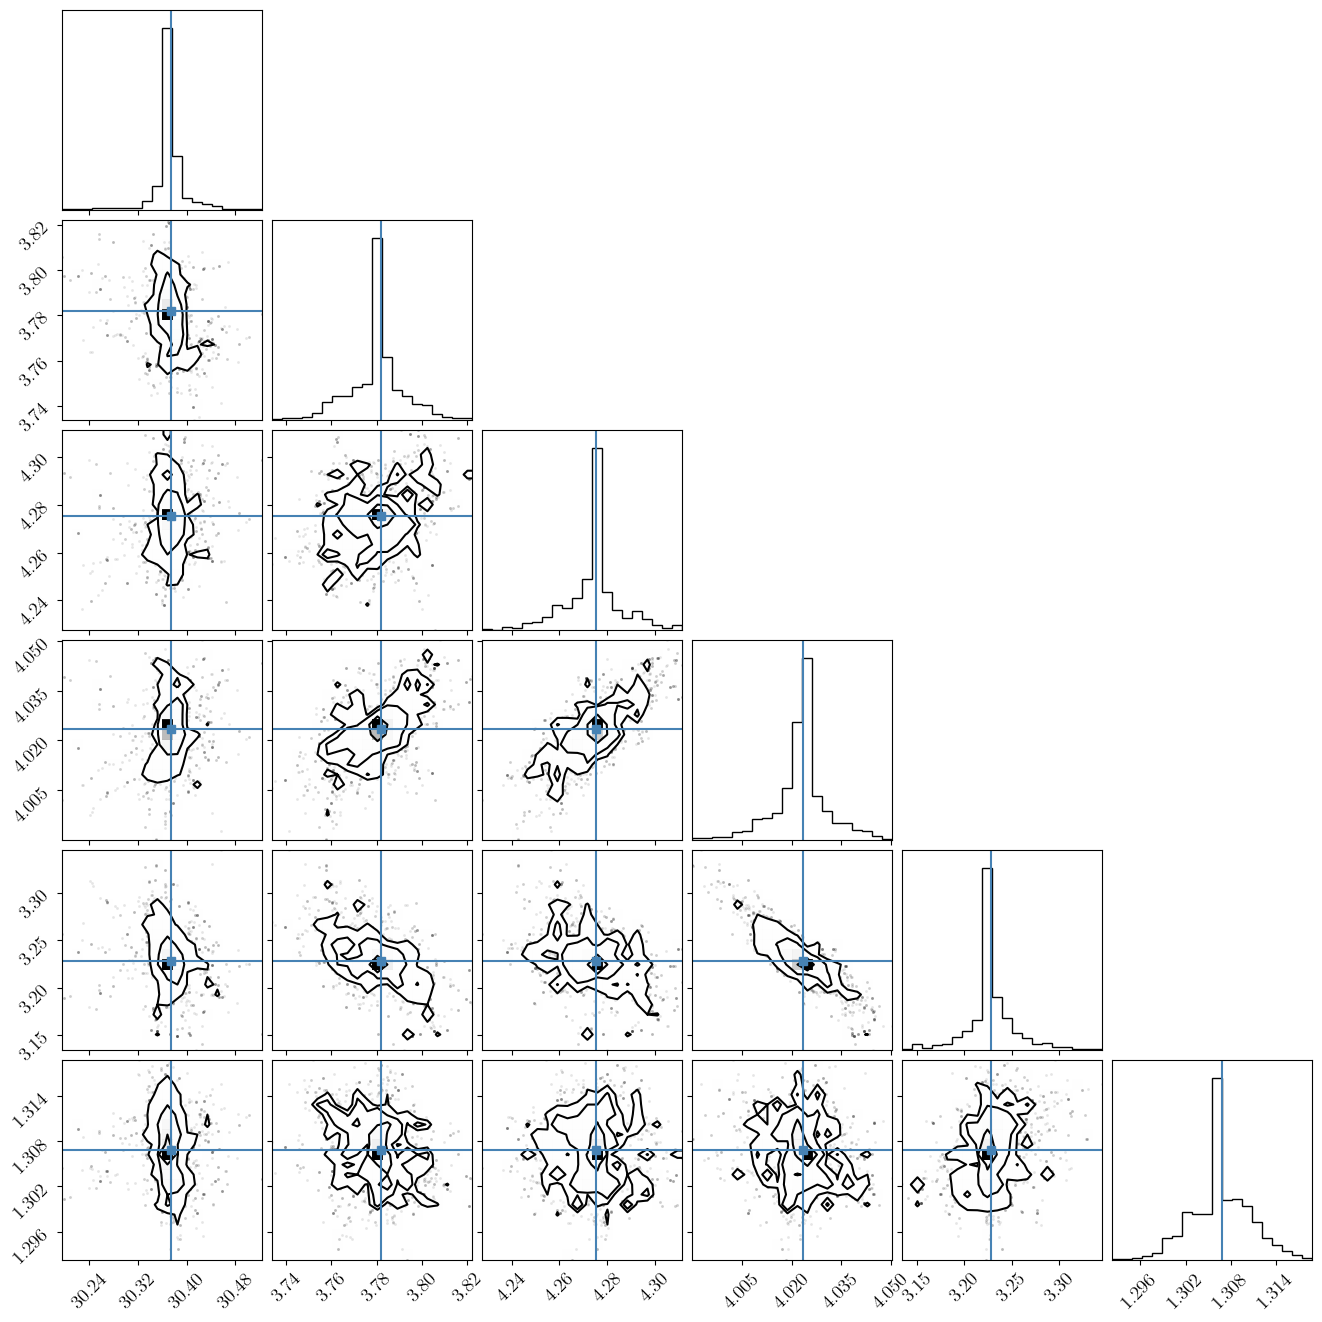

In [30]:
process_star(data.iloc[0].name, data.iloc[0])